# 32-point 16-bit FFT Simulation

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def plot_complex(X, ax, title):
    """
    plot a complex variable `X` on axis `ax` with title `title`.
    """
    re = ax.plot(np.real(X), 'x-', label='real')
    im = ax.plot(np.imag(X), 'x-', label='imag')
    ax.legend()
    ax.set_title(title)
    return re, im

def to_int(hexstr, bits):
    """
    Convert `bits`-bit representatino twos-complement hex string `hexstr` to an integer.   
    from https://stackoverflow.com/a/6727975/6115747.
    """
    value = int(hexstr, 16)
    if value & (1 << (bits - 1)):
        value -= 1 << bits
    return value

def int2hex(integer, digits):
    """
    Convert integer `integer` to `digits`-bit two's complement hex representation.
    """
    if integer >= 0:
        return hex(integer)[2:].zfill(digits)
    else:
        return hex(2**(4*digits) + integer)[2:]

# Generate test case `x`:

Text(0.5, 1.0, 'input')

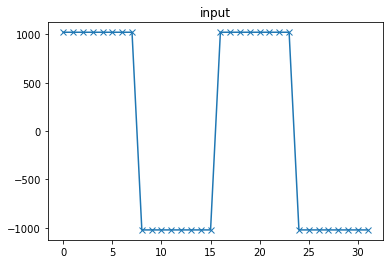

In [25]:
x = np.concatenate((1023*np.ones(8, dtype='int16'), 
                    -1023*np.ones(8, dtype='int16')))
x = np.concatenate((x, x))
plt.plot(x, 'x-')
plt.title("input")

### write `x` to `simulation/modelsim/rom/test_in.memh`:

In [26]:
with open("simulation/modelsim/rom/test_in.memh", "w") as f:
    for sample in x:
        f.write(int2hex(sample, 4) + "\n")

## NumPy (ground-truth) output:

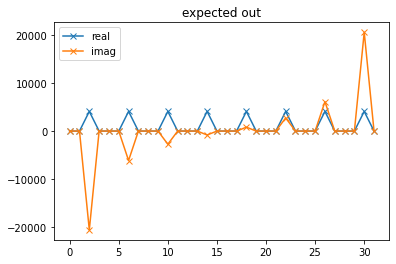

In [27]:
X = np.fft.fft(x)
fig, ax = plt.subplots()
_ = plot_complex(X, ax, "expected out")

### write to `simulation/modelsim/rom/gt_test_out.memh`:

In [28]:
with open("simulation/modelsim/rom/gt_test_out.memh", "w") as f:
    for sample in X:
        f.write(int2hex(int(np.real(sample)), 4) + int2hex(int(np.imag(sample)), 4) + "\n")

## Testbench output:
Note that the `fft_testbench` needs to be run to completion in modelsim in order to generate the file!

In [30]:
out = np.loadtxt("simulation/modelsim/rom/test_out.memh",
                 dtype='complex',
                 converters={0:lambda s: to_int(s[0:4], 16) + 1j*to_int(s[4:8], 16)})

([<matplotlib.lines.Line2D at 0x7f5cc6b930d0>],
 [<matplotlib.lines.Line2D at 0x7f5cc6b934f0>])

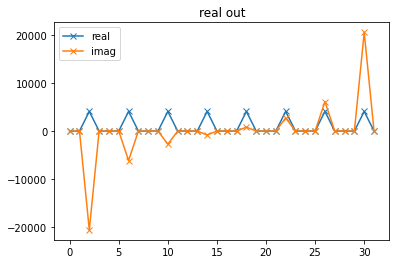

In [31]:
fig, ax = plt.subplots()
plot_complex(out, ax, "real out")